## My Kaggle Mini Project

[Kaggle competition link](https://www.kaggle.com/competitions/histopathologic-cancer-detection/submissions)<br>
[My repository link](https://github.com/YAGoOaR/CNN-Kaggle-Mini-Project)

### Step 1 Problem description


The challenge problem is to identify cancer in the input images. It is a binary classification where 1st class(label - 0) are images of healthy cells and the 2nd class images are images of cells that have metastatic cancer.

The input data is 96x96 pixels. However, labels indicate that cancer exists in middle 32x32 image square. Also we have 3 RGB channels, so the input is actually 96x96x3.

### Step 2 Exploratory data analysis
Let's see how many samples we have:

In [1]:
import numpy as np
import pandas as pd
import os

train_path = '../input/histopathologic-cancer-detection/train'
test_path = '../input/histopathologic-cancer-detection/test'

for name, path in ('train', train_path), ('test', test_path):
    print(name.capitalize() + ' - ', end='')
    numSamples = len(os.listdir(path))
    print(f'Sample count: {numSamples}')

Train - Sample count: 220025
Test - Sample count: 57458


We have 220025 train images and 57458 test images.
But to train a NN for the binary classification, we should make sure that our data is balanced(no disbalance between each class samples count).

0    130908
1     89117
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

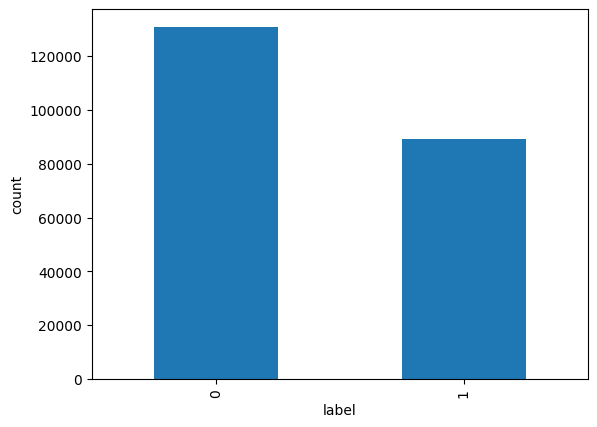

In [2]:
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
label10counts = train_labels['label'].value_counts()
print(label10counts)
label10counts.plot(kind='bar', xlabel='label', ylabel='count')

As we can see on the previous graph, we have more healthy cells images than unlealthy.
So let's make the sample count equal for each label.

0    89117
1    89117
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

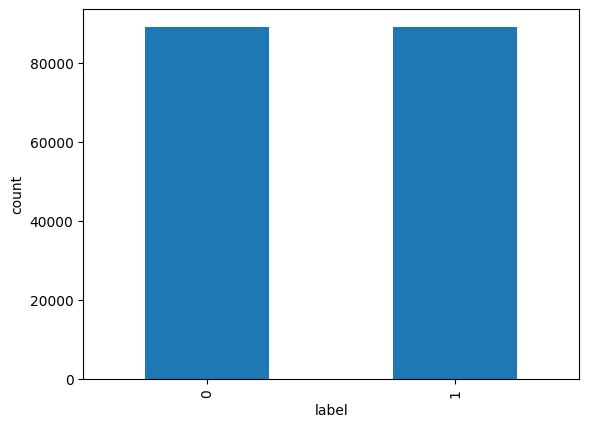

In [3]:
train_labels_1 = train_labels[train_labels['label'] == 1]
train_labels_0 = train_labels[train_labels['label'] == 0]
train_labels = pd.concat(
    [train_labels_1, train_labels_0.sample(n=train_labels_1.shape[0], random_state=42)]
).sample(
    frac=1, random_state=42
).reset_index(
    drop=True
)
label10counts = train_labels['label'].value_counts()
print(label10counts)
label10counts.plot(kind='bar', xlabel='label', ylabel='count')

Now the sample dataframe is balanced.
Next, let's look at the images to visually see the problem.

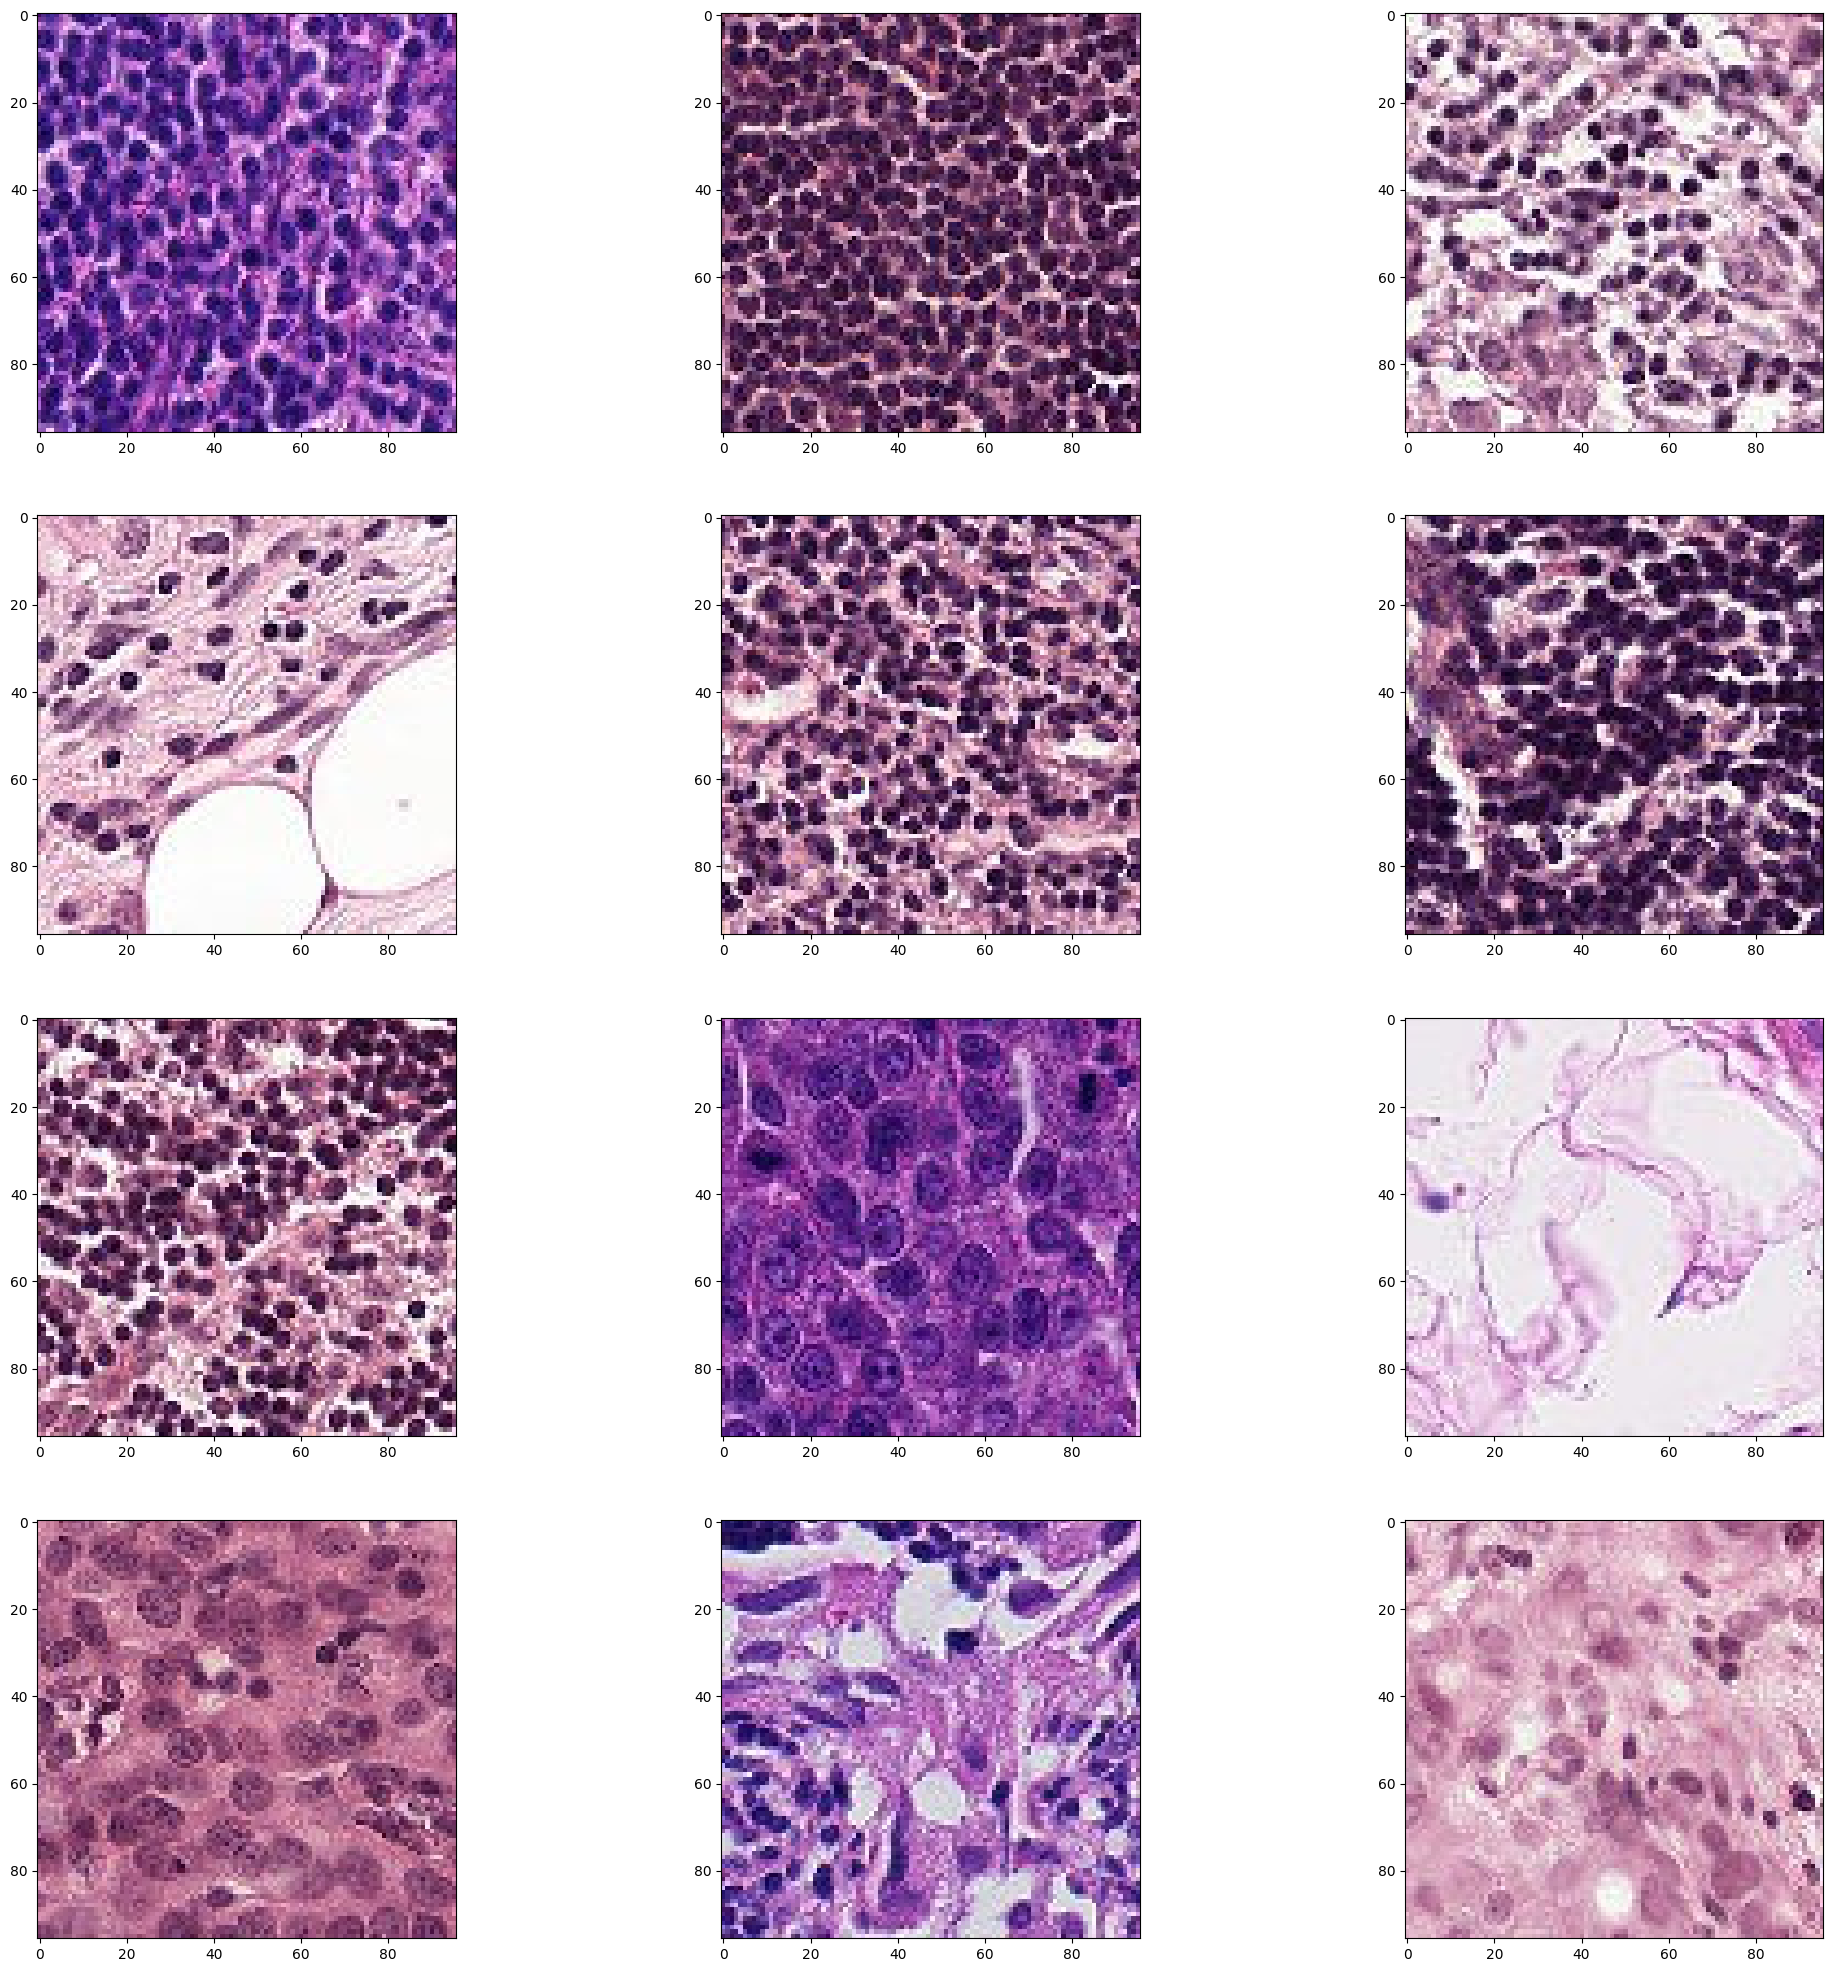

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def imgPathFromLabel(path, label):
    return os.path.join(path, f'{label}.tif')

def getImgFromLabel(label, test=False):
    path = test and test_path or train_path
    return mpimg.imread(imgPathFromLabel(path, label))

fig, ax = plt.subplots(4, 3, figsize=(25, 25))

sample_ids = np.random.choice(train_labels['id'], 12)

for i in range(sample_ids.shape[0]):
    ax = plt.subplot(4, 3, i+1)
    ax.imshow(getImgFromLabel(sample_ids[i]))

Next, let's make data generators to prepare the data for NN training.<br>
Let's split the train data to train and test dataframes(we don't use input test folder because we don't know labels for it. So we create train and test dataframes only from known data).<br>
We should also rescale the data pixel brightness(for each channel) to float value by dividing it by maximum intensivity (255).<br>
For 'id' column, we chould add the .tif file extension to get the input file names ready to be used by the generators.<br>
Also the labels should be converted to string values.<br>

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (
    Dense, 
    Activation, 
    Dropout, 
    Flatten, 
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    PReLU
)
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

train, valid = train_test_split(
    train_labels, 
    random_state=42, 
    test_size=0.25, 
    stratify=train_labels['label']
)
train['id'] += '.tif'
valid['id'] += '.tif'
train['label'] = train['label'].astype(str)
valid['label'] = valid['label'].astype(str)

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train, 
    directory=train_path, 
    x_col='id', 
    y_col='label',
    class_mode='binary',
    target_size=(96, 96)
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe = valid, 
    directory=train_path, 
    x_col='id', 
    y_col='label',
    class_mode='binary',
    target_size=(96, 96)
)

Found 133675 validated image filenames belonging to 2 classes.
Found 44559 validated image filenames belonging to 2 classes.


The data is prepared to use by the neural network now!<br>
## Step 3 Model architecture
Finally, let's design the model architecture!<br>

At first, I used a standard deep CNN - VGGNet model architecture. I chose this model because it is a simple, popular and trustworthy model and it is definitelly good enough for binary classification.<br>
Of course, we should try something more complex to reach higher places on the leaderbord but I am only beginning to learn neural networks so my goal is just to make a simple and understandable architecture that will be trained in reasonable period of time.<br>

But I made a conclusion that the standard VGGNet model is too big for this task(and trains too long) so in these examples let's use a bit simplified version of VGGNet so it will be trained faster.

After creating the model, let's see the architecture info by using `model.summary()` command.<br>

In [6]:
model1 = Sequential([
    Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    Activation('relu'),
    Conv2D(32, (3, 3)),
    Activation('relu'),
    MaxPooling2D(),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(),
    
    Flatten(),

    Dense(64),
    Activation('relu'),

    Dense(1),
    Activation('sigmoid'),
])

model1.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 64)        0

Epoch 1/8
4177/4177 [==============================] - 221s 52ms/step - loss: 0.4834 - accuracy: 0.7641 - val_loss: 0.3565 - val_accuracy: 0.8483
Epoch 2/8
4177/4177 [==============================] - 213s 51ms/step - loss: 0.3351 - accuracy: 0.8546 - val_loss: 0.2978 - val_accuracy: 0.8746
Epoch 3/8
4177/4177 [==============================] - 209s 50ms/step - loss: 0.2814 - accuracy: 0.8826 - val_loss: 0.2612 - val_accuracy: 0.8908
Epoch 4/8
4177/4177 [==============================] - 208s 50ms/step - loss: 0.2349 - accuracy: 0.9049 - val_loss: 0.2489 - val_accuracy: 0.8977
Epoch 5/8
4177/4177 [==============================] - 208s 50ms/step - loss: 0.1983 - accuracy: 0.9207 - val_loss: 0.2719 - val_accuracy: 0.8955
Epoch 6/8
4177/4177 [==============================] - 209s 50ms/step - loss: 0.1600 - accuracy: 0.9378 - val_loss: 0.3072 - val_accuracy: 0.8884
Epoch 7/8
4177/4177 [==============================] - 208s 50ms/step - loss: 0.1247 - accuracy: 0.9529 - val_loss: 0.3670 -

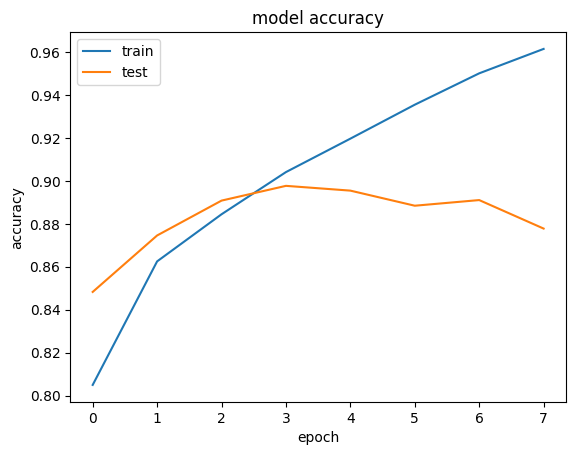

In [7]:
epochs = 8

history = model1.fit(
    x=train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    validation_steps=valid_generator.n//valid_generator.batch_size,
    epochs=epochs
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It seems that it is overfitting now. <br>
Let's add dropouts and change the layer to PReLU.

In [8]:
model2 = Sequential([
    Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    PReLU(Constant(0.25)),
    Conv2D(32, (3, 3)),
    PReLU(Constant(0.25)),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(64, (3, 3)),
    PReLU(Constant(0.25)),
    Conv2D(64, (3, 3)),
    PReLU(Constant(0.25)),
    MaxPooling2D(),
    BatchNormalization(),
    
    Flatten(),
    Dropout(0.25),
    Dense(64),
    PReLU(Constant(0.25)),

    Dropout(0.25),
    Dense(1),
    Activation('sigmoid'),
])

model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
p_re_lu (PReLU)              (None, 94, 94, 32)        282752    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 92, 92, 32)        270848    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 44, 44, 64)       

Epoch 1/8
4177/4177 [==============================] - 430s 103ms/step - loss: 0.9391 - accuracy: 0.7564 - val_loss: 0.4643 - val_accuracy: 0.8091
Epoch 2/8
4177/4177 [==============================] - 429s 103ms/step - loss: 0.3864 - accuracy: 0.8330 - val_loss: 1.2078 - val_accuracy: 0.6881
Epoch 3/8
4177/4177 [==============================] - 440s 105ms/step - loss: 0.3215 - accuracy: 0.8656 - val_loss: 0.3469 - val_accuracy: 0.8580
Epoch 4/8
4177/4177 [==============================] - 436s 104ms/step - loss: 0.2699 - accuracy: 0.8905 - val_loss: 0.5237 - val_accuracy: 0.7971
Epoch 5/8
4177/4177 [==============================] - 447s 107ms/step - loss: 0.2224 - accuracy: 0.9111 - val_loss: 0.3889 - val_accuracy: 0.8435
Epoch 6/8
4177/4177 [==============================] - 445s 107ms/step - loss: 0.1907 - accuracy: 0.9242 - val_loss: 0.3596 - val_accuracy: 0.8627
Epoch 7/8
4177/4177 [==============================] - 442s 106ms/step - loss: 0.1600 - accuracy: 0.9375 - val_loss: 0

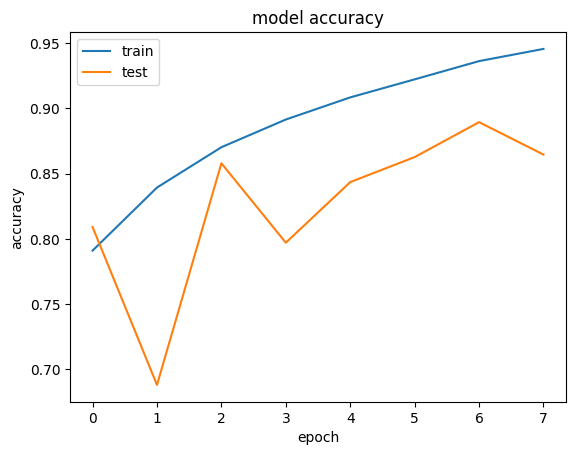

In [9]:
epochs = 8

history = model2.fit(
    x=train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    validation_steps=valid_generator.n//valid_generator.batch_size,
    epochs=epochs
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It seems that PReLU learns longer for the same amount of epochs. And we had no positive effect.<br>
Let's add Leaky ReLU and increase dropouts.

In [10]:
from keras.layers.advanced_activations import LeakyReLU

model3 = Sequential([
    Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    LeakyReLU(),
    Conv2D(32, (3, 3)),
    LeakyReLU(),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(64, (3, 3)),
    LeakyReLU(),
    Conv2D(64, (3, 3)),
    LeakyReLU(),
    MaxPooling2D(),
    BatchNormalization(),
            
    Flatten(),
    Dropout(0.5),
    Dense(64),
    LeakyReLU(),

    Dropout(0.5),
    Dense(1),
    Activation('sigmoid'),
])

model3.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/8
4177/4177 [==============================] - 248s 59ms/step - loss: 0.9250 - accuracy: 0.7611 - val_loss: 0.4730 - val_accuracy: 0.7840
Epoch 2/8
4177/4177 [==============================] - 237s 57ms/step - loss: 0.4106 - accuracy: 0.8201 - val_loss: 0.5427 - val_accuracy: 0.7722
Epoch 3/8
4177/4177 [==============================] - 234s 56ms/step - loss: 0.3810 - accuracy: 0.8354 - val_loss: 0.5251 - val_accuracy: 0.7130
Epoch 4/8
4177/4177 [==============================] - 237s 57ms/step - loss: 0.3465 - accuracy: 0.8519 - val_loss: 0.3326 - val_accuracy: 0.8624
Epoch 5/8
4177/4177 [==============================] - 238s 57ms/step - loss: 0.3236 - accuracy: 0.8637 - val_loss: 0.3514 - val_accuracy: 0.8499
Epoch 6/8
4177/4177 [==============================] - 234s 56ms/step - loss: 0.3060 - accuracy: 0.8725 - val_loss: 0.3292 - val_accuracy: 0.8607
Epoch 7/8
4177/4177 [==============================] - 238s 57ms/step - loss: 0.2962 - accuracy: 0.8768 - val_loss: 0.3124 -

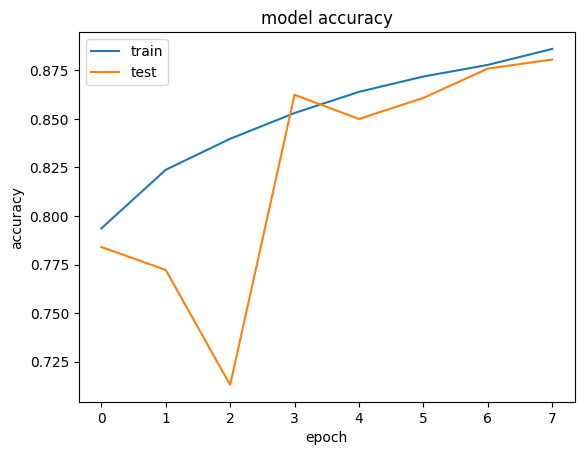

In [11]:
epochs = 8

history = model3.fit(
    x=train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    validation_steps=valid_generator.n//valid_generator.batch_size,
    epochs=epochs,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The validation accuracy seems to be better now. So we can say that it helped to add a Leaky ReLU layer.

### Step 4 Results and analysis
We have good enough resuts now. Validation accuracy is ~0.88.<br>
We can say, that according to our tests, it helped to add a Leaky ReLU layer.<br>
We also could notice that dropout layer improved results, because we can see that it reduced overfitting compared to our first result.<br>
And the more dropouts we have, the less overfitting we see.(but training learning speed can be slower because of it).<br>
Also I tried lowering optimizer learning rate and increasing epochs, I had nearly same results while spent more time, therefore, there is no sense to do it.<br>

### Step 4 Conclusion
Suming up, we tried different architectures of convolutional neural networks for this task.<br>
It helped to switch from relu to leaky relu activations, and it helped to use dropouts in our layers.<br>
But I would try such things as using pretrained network's weights to better understand the features of the image classes.<br>
Also the thing that would help is to use all the training data(when it is not balanced) by splitting it to batches with equal element count for each class, so we would cover more different data(we just dropped extra class' elements this time).

Let's submit the results.

In [ ]:
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
test_df = submission.copy()
test_df.head()

In [ ]:
test_df['file'] = test_df['id'] + '.tif'
test_df.head()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=test_path, x_col='file', batch_size=64, seed=42, shuffle=False, class_mode=None, target_size=(96, 96))

In [ ]:

preds = model3.predict(test_generator, steps=test_generator.n/64, verbose=True)
preds = [i >= 0.5 and 1 or 0 for i in preds]


In [ ]:
submission['label'] = preds
submission.head()

In [ ]:
submission.to_csv('submission.csv', header=True, index=False)